In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

________________________________

In [4]:
network = 'tarbase'
ppi = 'TF'
target_homology = 'mix' #'wgd', 'ssd' or 'mix'
remove_pre_2R = True

In [5]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{ppi}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi}.tsv'
else:
	raise ValueError("target_homology must be 'wdg', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [6]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [7]:
df_wgd = df_1
df_ssd = df_2

In [8]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  537


In [9]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_pre_2R:
	df_ssd = df_ssd[~(df_ssd["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd["miRNA_2"].apply(all_clades_in_pre2R))]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  225


In [10]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [11]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  220


In [12]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [13]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [14]:
df_wgd_nbifan = df_wgd['n_relevant_bifan'].astype(int)
df_ssd_nbifan = df_ssd['n_relevant_bifan'].astype(int)

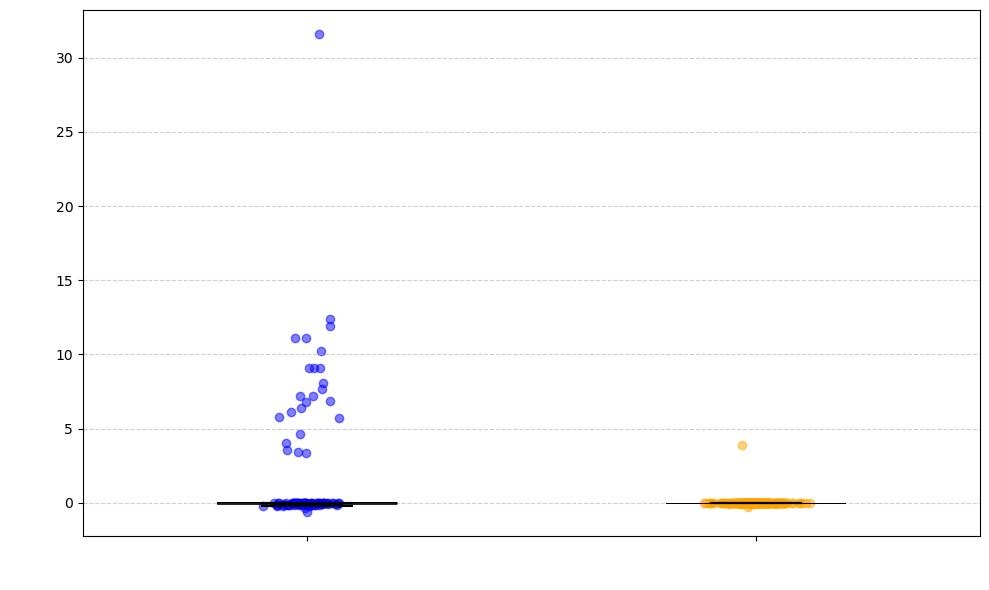

Number of WGD pairs:  108
Number of SSD pairs:  220


In [15]:
# Sample sizes
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

# Jittered x positions
x_wgd = np.random.normal(0, 0.04, size=n_wgd)
x_ssd = np.random.normal(1, 0.04, size=n_ssd)

plt.figure(figsize=(10, 6))

# Boxplot with transparent fill and notches
box = plt.boxplot(
    [df_wgd_zscores, df_ssd_zscores],
    positions=[0, 1],
    widths=0.4,
    notch=True,
    patch_artist=True,
    showfliers=False
)

# Make boxes transparent
for patch in box['boxes']:
	patch.set_facecolor('none')
	patch.set_edgecolor('black')
	patch.set_linewidth(0.7)

# Customize other boxplot parts
for element in ['medians', 'whiskers', 'caps']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.5)
        # width of the whiskers
        if element == 'whiskers':
            line.set_alpha(0.5)

# Jittered dots
plt.scatter(x_wgd, df_wgd_zscores, alpha=0.5, color='blue', label='WGD')
plt.scatter(x_ssd, df_ssd_zscores, alpha=0.5, color='orange', label='SSD')

# Labels
plt.xticks([0, 1], [f' ', f' '], fontsize=25)
plt.ylabel(' ', fontsize=30)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

In [16]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS test results with parameters:\nnetwork={network}\nppi={ppi}\ntarget_homology={target_homology}\nremove_pre_2R={remove_pre_2R}")
print(100 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
ppi=TF
target_homology=mix
remove_pre_2R=True
KS statistic: 0.3808080808080808, p-value: 6.792861560501509e-10


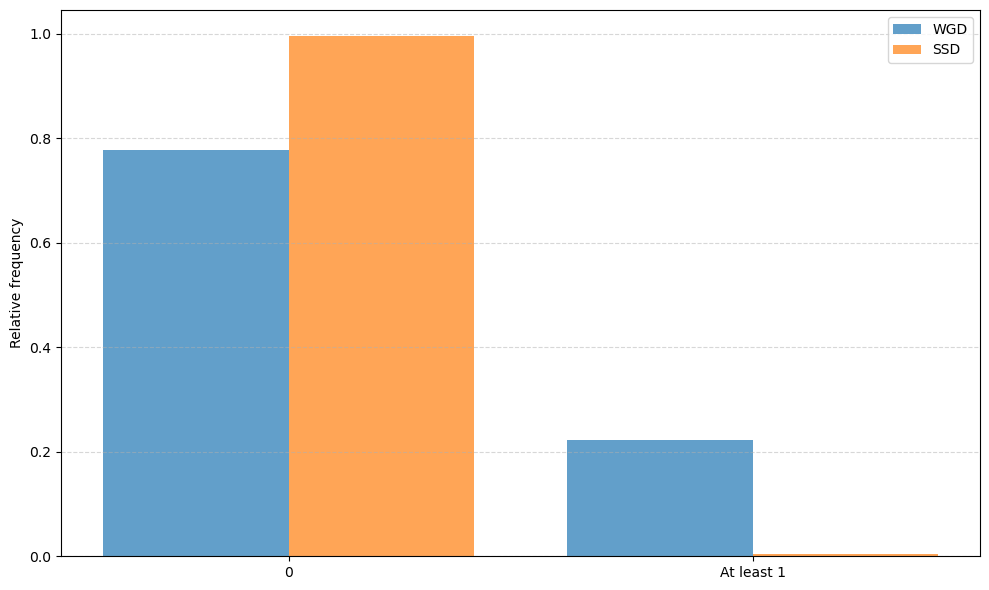

WGD pairs with 0 relevant bifan:  84
SSD pairs with 0 relevant bifan:  219
WGD pairs with at least 1 relevant bifan:  24
SSD pairs with at least 1 relevant bifan:  1


In [17]:
def bin_bifans(count):
    if count == 0:
        return '0'
    else:
        return 'At least 1'

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(['0', 'At least 1'], fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(['0', 'At least 1'], fill_value=0)

# Plot
labels = ['0', 'At least 1']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('')
plt.ylabel('Relative frequency')
plt.title('')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("WGD pairs with 0 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] == 0]))
print("SSD pairs with 0 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] == 0]))
print("WGD pairs with at least 1 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] > 0]))
print("SSD pairs with at least 1 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] > 0]))

In [18]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
114,MIR15B,MIR16-2,443,1315,379,0.058,0.242149,1,56,3.8901713825528814,4.501621877484041e-07


In [19]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,0.175,0.412765,3,1,6.84408694023446,8.558861397389705e-10
2,MIR103A1,MIR107,950,959,927,0.161,0.416028,3,4,6.824065769756391,4.833239364288033e-10
3,MIR103A2,MIR107,1075,959,930,0.209,0.455323,3,2,6.129715017854181,2.8793094575263467e-09
5,MIR106A,MIR17,538,1373,308,0.090,0.299833,2,4,6.370206653966418,8.7717610952609e-12
43,MIR181A1,MIR181A2,495,869,466,0.044,0.205095,1,44,4.661252270288824,1.32484900827734e-09
54,MIR196A2,MIR196B,250,145,137,0.001,0.031607,1,1,31.606961258558215,0.0
68,MIR23A,MIR23B,549,954,514,0.059,0.252030,2,2,7.701471440770052,3.4416913763379853e-15
69,MIR24-1,MIR24-2,756,867,755,0.078,0.286210,3,0,10.209297113232964,0.0
70,MIR26A1,MIR26A2,619,600,599,0.030,0.170587,1,30,5.686240703077327,9.867662242868391e-13
74,MIR29A,MIR29C,1076,460,440,0.048,0.236000,1,44,4.033898305084746,2.040154822857687e-09


In [20]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['n_relevant_bifan'].astype(float) > 0]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
114,MIR15B,MIR16-2,443,1315,379,0.058,0.242149,1,56,3.8901713825528814,4.501621877484041e-07


In [21]:
df_wgd_high_z = df_wgd[df_wgd['n_relevant_bifan'].astype(float) > 0]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,0.175,0.412765,3,1,6.84408694023446,8.558861397389705e-10
2,MIR103A1,MIR107,950,959,927,0.161,0.416028,3,4,6.824065769756391,4.833239364288033e-10
3,MIR103A2,MIR107,1075,959,930,0.209,0.455323,3,2,6.129715017854181,2.8793094575263467e-09
5,MIR106A,MIR17,538,1373,308,0.090,0.299833,2,4,6.370206653966418,8.7717610952609e-12
43,MIR181A1,MIR181A2,495,869,466,0.044,0.205095,1,44,4.661252270288824,1.32484900827734e-09
54,MIR196A2,MIR196B,250,145,137,0.001,0.031607,1,1,31.606961258558215,0.0
68,MIR23A,MIR23B,549,954,514,0.059,0.252030,2,2,7.701471440770052,3.4416913763379853e-15
69,MIR24-1,MIR24-2,756,867,755,0.078,0.286210,3,0,10.209297113232964,0.0
70,MIR26A1,MIR26A2,619,600,599,0.030,0.170587,1,30,5.686240703077327,9.867662242868391e-13
74,MIR29A,MIR29C,1076,460,440,0.048,0.236000,1,44,4.033898305084746,2.040154822857687e-09
